<a href="https://colab.research.google.com/github/youngseo21/esaa_22/blob/main/regression(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import package
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## **06 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷**
____


### | **릿지 회귀**
___
- 사이킷런의 `Ridge` 클래스는 릿지 회귀를 구현한다.
- `Ridge` 클래스의 주요 생성 파라미터는 `alpha`이며, 릿지 회귀의 alpha L2 규제 계수를 의미한다.
- 앞 예제의 보스턴 주택 가격을 `Ridge` 클래스를 이용해 다시 예측하고, 예측 성능을 `corss_val_score()`로 평가한다.
- 이때 앞에서 만든 Feature 데이터셋인 `X_data`와 Target 데이터셋인 `y_target`을 그대로 이용한다.

In [ ]:
# 앞의 LinearRegression 예제에서 분할한 feature 데이터셋인 X_data과 Target 데이터셋인 Y_target 데이터셋을 그대로 이용 
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# boston 데이터셋 로드
boston = load_boston()

# boston 데이터셋을 DataFrame으로 변환 
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# boston dataset의 target array는 주택 가격 
# PRICE Column으로 DataFrame에 추가
bostonDF['PRICE'] = boston.target
print('Boston 데이타셋 크기 : ', bostonDF.shape)

# Target/Feature 데이터셋
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis = 1, inplace = False)

# model fitting
ridge = Ridge(alpha = 10)

# model test
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 folds 의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 3))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 3))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

Boston 데이타셋 크기 :  (506, 14)
 5 folds 의 개별 Negative MSE scores :  [-11.422 -24.294 -28.144 -74.599 -28.517]
 5 folds 의 개별 RMSE scores :  [3.38  4.929 5.305 8.637 5.34 ]
 5 folds 의 평균 RMSE : 5.518 


- 릿지의 5개 폴드 세트의 평균 RMSE는 5.518이다. 앞에서 학습한 규제가 없는 LinearRegression의 평균 RMSE 값인 5.829보다 작은 값으로, 더 뛰어난 예측 성능을 보여준다는 것을 알 수 있다.
- 이번에는 릿지의 `alpha` 값을 0, 0.1, 1, 10, 100으로 변화시키면서 RMSE와 회귀 계수 값의 변화를 살펴본다.
- alpha 값을 변할 때 RMSE와 각 Feature의 회귀 계수가 달라지는 것을 시각화하고, 그 값을 DataFrame에 저장하는 예제이다.
- 먼저 alpha 값의 변화에 따른 5 폴드의 평균 RMSE 값을 반환하는 코드부터 작성해보자.

In [ ]:
# alpha값을 0, 0.1, 1, 10, 100 으로 변경하면서 RMSE 측정

# Ridge에 사용될 alpha 파라미터의 값들을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse 구함
for alpha in alphas :
    ridge = Ridge(alpha = alpha)

    # cross_val_score를 이용하여 5 fold의 평균 RMSE 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds의 평균 RMSE : {1:.3f} '.format(alpha,avg_rmse))

alpha 0 일 때 5 folds의 평균 RMSE : 5.829 
alpha 0.1 일 때 5 folds의 평균 RMSE : 5.788 
alpha 1 일 때 5 folds의 평균 RMSE : 5.653 
alpha 10 일 때 5 folds의 평균 RMSE : 5.518 
alpha 100 일 때 5 folds의 평균 RMSE : 5.330 


- alpha가 100일 때, 평균 RMSE가 5.330으로 가장 작다.
- 이번에는 alpha 값의 변화에 따른 Feature의 회귀 계수 값을 가로 막대 그래프로 시각화해본다.
- 회귀 계수를 Ridge 객체의 `coef_` 속성에서 추출한 후, Series 객체로 만들고, `Seaborn`의 가로 막대 차트로 표시하고, DataFrame에 alpha 값 별 회귀 계수를 저장한다. 

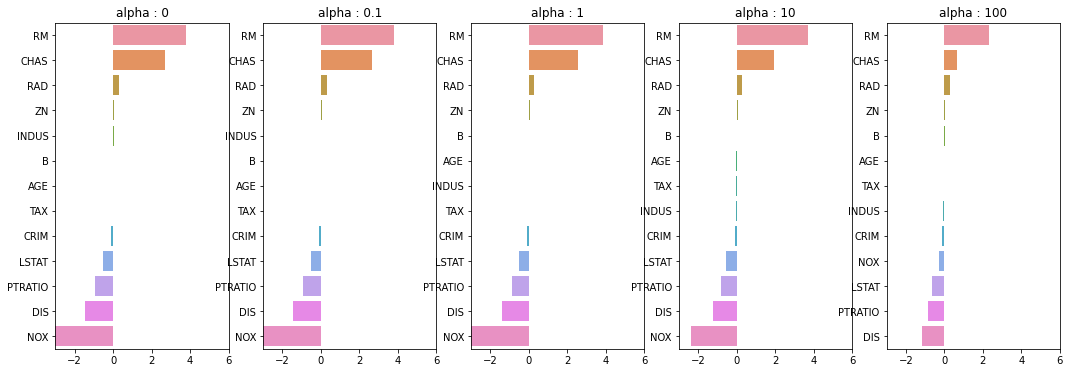

In [ ]:
# alpha 값 별 회귀 계수 값을 시각화하기 위해, 5개의 열로 된 matplotlib 축 생성  
fig, axs = plt.subplots(figsize = (18 ,6) , nrows = 1 , ncols = 5)

# alpha 값 별 회귀 계수 값을 저장하기 위한 빈 DataFrame 생성  
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장
# pos는 axis의 위치 지정
for pos , alpha in enumerate(alphas) :
    # model fitting
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data, y_target)

    # alpha에 따른 Feature 별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가 
    coeff = pd.Series(data = ridge.coef_, index = X_data.columns )
    colname = 'alpha : ' + str(alpha) # Column 이름 설정
    coeff_df[colname] = coeff

    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화
    coeff = coeff.sort_values(ascending = False) # 회귀 계수 값이 높은 순으로 표현
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3 ,6)
    sns.barplot(x = coeff.values , y = coeff.index, ax = axs[pos])

# for 문 밖에서 matplotlib의 show() 호출
plt.show()

- alpha 값을 증가시킬수록 회귀 계수 값이 작아진다. 특히 Nox Feature의 경우, alpha 값을 증가함에 따라, 회귀 계수가 눈에 띄게 작아진다.

In [ ]:
# alpha에 따른 Feature 별 회귀 계수를 DataFrame으로 변환
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha : ' + str(ridge_alphas[0])
coeff_df.sort_values(by = sort_column, ascending = False)

,alpha : 0,alpha : 0.1,alpha : 1,alpha : 10,alpha : 100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


- alpha 값이 증가하면서 회귀 계수가 지속적으로 작아진다.
- 다만, 릿지 회귀는 회귀 계수를 0으로 만들지 않는다.

### | **라쏘 회귀**
___
- W의 절댓값에 페널티를 부여하는 L1 규제를 선형 회귀에 적용한 것이 라쏘(Lasso) 회귀이다.
- 즉, L1 규제는 $alpha * ||W||_1$를 의미하며, 라쏘 회귀 비용 함수의 목표는 $RSS(W) + alpha * ||W||_1$를 최소화하는 W를 찾는 것이다.
- L2 규제는 회귀 계수의 크기를 감소시키는 반면, L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거한다. 이러한 측면에서 L1 규제는 적절한 Feature만 회귀에 포함시키는 Feature 선택을 수행한다고 볼 수 있다.
- 사이킷런은 `Lasso` 클래스를 통해 라쏘 회귀를 구현한다.
- `Lasso` 클래스의 주요 생성 파라미터는 `alpha`로, 이는 라쏘 회귀의 alpha L1 규제 계수를 의미한다.
- 릿지 회귀 예제 코드에서 한 것처럼, `Lasso` 클래스를 이용해, `alpha` 값을 변화시키면서 결과를 출력하는 함수를 만들어보자.
- `get_linear_ret_eval()` 함수 : 회귀 모델의 이름. alpha 값들의 리스트, Feature 데이터셋과 Target 데이터셋을 입력 받아, alpha 값에 따른 폴드 평균 RMSE 값을 출력하고, 회귀 계수 값들을 DataFrame으로 반환하는 함수 

In [ ]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환 
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, 
                        verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name , '#######')
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha = param)
        elif model_name =='Lasso': model = Lasso(alpha = param)
        elif model_name =='ElasticNet': model = ElasticNet(alpha = param, l1_ratio = 0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring = "neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE : {1:.3f} '.format(param, avg_rmse))
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        
        model.fit(X_data_n , y_target_n)
        if return_coeff:
            # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
            coeff = pd.Series(data = model.coef_ , index = X_data_n.columns )
            colname ='alpha : ' + str(param)
            coeff_df[colname] = coeff
    
    return coeff_df
# end of get_linear_regre_eval

- alpha 값은 [0.07, 0.1, 0.5, 1, 3]을 입력하고 모델명을 'Lasso'로 입력해, 라쏘 모델을 기반으로 alpha 값에 따라 RMSE와 회귀 계수들이 어떻게 변화하는지 출력해보자.

In [ ]:
# 라쏘에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params = lasso_alphas, X_data_n = X_data, y_target_n = y_target)

#######  Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE : 5.612 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.615 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE : 5.669 
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.776 
alpha 3일 때 5 폴드 세트의 평균 RMSE : 6.189 


- alpha가 0.07 일 때, 평균 RMSE 값이 가장 작다.
- 릿지 회귀에서의 평균 RMSE 값인 5.330보다는 크지만, 규제가 없는 LinearRegression의 평균 RMSE 값인 5.829보다는 작다.
- alpha 값에 따른 Feature 별 회귀 계수를 출력해보자.

In [ ]:
# 반환된 coeff_lasso_df를 첫번째 Column 순으로 내림차순 정렬하여 회귀계수 DataFrame 력
sort_column = 'alpha : ' + str(lasso_alphas[0])
coeff_lasso_df.sort_values(by = sort_column, ascending = False) # 내림차순

,alpha : 0.07,alpha : 0.1,alpha : 0.5,alpha : 1,alpha : 3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


- alpha의 크기가 증가함에 따라 일부 Feature의 회귀 계수가 아예 0으로 바뀐다.
- NOX 속성은 alpha가 0.07일 때부터 회귀 계수가 0이며, alpha가 증가하면서 INDUS, CHAS와 같은 Feature의 회귀 계수가 0으로 바뀐다.
- 회귀 계수가 0인 Feature는 회귀 식에서 제외되면서, Feature 선택의 효과를 얻을 수 있다.

### | **엘라스틱넷 회귀**
___
- 엘라스틱넷(Elastic Net) 회귀는 L2 규제와 L1 규제를 결합한 회귀이다.
- 따라서 엘라스틱넷 회귀에서 비용 함수의 목표는 $$RSS(W) + alpha2 * ||W||_2^2 + alpha1 * ||W||_1$$ 식을 최소화하는 W를 찾는 것이다.
- 라쏘 회귀는 서로 상관관계가 높은 Feature들의 경우, 이들 중 중요한 Feature만을 선택하고, 다른 Feature들은 회귀 계수를 모두 0으로 만든다. 이렇게 되면, alpha 값에 따라 회귀 계수의 값이 급격하게 변할 수 있는데, 엘라스틱넷 회귀는 이를 완화하기 위해 라쏘 회귀에 L2 규제를 추가했다.
- 다만 L1과 L2를 결합하여 규제를 적용하기 때문에, 엘라스틱넷 회귀는 수행시간이 상대적으로 오래 걸린다는 단점을 가지고 있다.
- 사이킷런은 `ElasticNet` 클래스를 통해 엘라스틱넷 회귀를 구현한다.
- `ElasticNet` 클래스의 주요 생성 파라미터는 `alpha`와 `l1_ratio`이다.
  + `ElasticNet` 클래스의 `alpha`는 `Ridge`나 `Lasso` 클래스의 `alpha` 값과는 다르다. 엘라스틱의 규제는 $$a * L1 + b * L2$$로 정의되는데, 이때, a는 L1 규제의 alpha 값, b는 L2 규제의 alpha 값이다. 따라서 `ElasticNet` 클래스의 주요 생성 파라미터는 다음과 같은 의미를 가지고 있다.
  + `alpha` : a + b
  + `l1_ratio` : a / (a + b)
  + 예를 들어, `l1_ratio` 가 0이면 a가 0이므로, L2 규제를 의미한다.
- ElasticNet 클래스를 이용해 릿지, 라쏘 회귀 예제 코드처럼 엘라스틱넷 alpha 값을 바꾸면서 평균 RMSE와 각 Feature의 회귀 계수를 출력해보자.
- 앞에서 생성한 `get_linear_reg_eval()` 함수를 이용한다.


In [ ]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의 
elastic_alphas = [ 0.07, 0.1, 0.5, 1, 3]

# get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params = elastic_alphas, X_data_n = X_data, y_target_n = y_target)

#######  ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE : 5.542 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.526 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE : 5.467 
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.597 
alpha 3일 때 5 폴드 세트의 평균 RMSE : 6.068 


In [ ]:
# 반환된 coeff_elastic_df를 내림차순 정렬하여 회귀계수 DataFrame 출력
sort_column = 'alpha : ' + str(elastic_alphas[0])
coeff_elastic_df.sort_values(by = sort_column, ascending = False)

,alpha : 0.07,alpha : 0.1,alpha : 0.5,alpha : 1,alpha : 3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


- alpha가 0.5일 때, RMSE가 5.467로 가장 좋은 예측 성능을 보이고 있다.
- Feature들의 회귀 계수들 값이 라쏘보다는 상대적으로 0이 되는 값이 적은 것을 알 수 있다.
- 릿지, 라쏘, 엘라스틱넷 회귀 중 어떤 것이 가장 좋은지는 상황에 따라 다르다. 따라서 각각의 알고리즘에서 하이퍼 파라미터를 변경해 가며, 최적의 예측 성능을 찾아내야 한다.

### | **선형 회귀 모델을 위한 데이터 변환**
___
- 선형 회귀 모델과 같은 선형 모델은 일반적으로 Feature와 Target 값 간에 선형의 관계가 있다고 가정하고, 데이터들을 가장 잘 표현하는 최적의 선형 함수를 찾아, 결과값을 예측한다.
- 선형 모델은 Feature와 Target 값의 분포로 정규 분포를 선호한다.
  + 특히 Target 값의 경우, 특정 값으로 치우친 왜곡된 분포(Skew distribution)일 경우, 예측 성능에 부정적인 영향을 미칠 수 있다.
  + Feature 값 역시 Target 값보다는 덜하지만, 왜곡된 분포로 인해 예측 성능에 저하될 수 있다.
- 따라서 선형 회귀 모델을 적용하기 전에 먼저 데이터를 스케일링하거나 정규화하는 것이 일반적이다. 다만, 스케일링/정규화 작업을 한다고 해서 무조건 예측 성능이 향상되는 것은 아니다.
- 일반적으로 중요 Feature나 Target 값의 분포가 심하게 왜곡되었을 때, 이러한 변환 작업을 수행한다.
- 사이킷런을 이용해 Feature 데이터셋을 다음과 같이 변환한다.
  1. `StandardScaler` 클래스를 이용해 평균이 0, 분산이 1인 표준 정규 분포를 가진 데이터셋으로 변환하거나 `MinMaxScaler` 클래스를 이용해 최솟값이 0이고, 최댓값이 1인 값으로 정규화를 수행한다.
  2. 스케일링/정규화를 수행한 데이터셋에 다시 다항 특성을 적용하여 변환한다. 1번을 적용했는데도, 예측 성능이 향상되지 않을 경우 이와 같은 방법을 적용한다.
  3. 원래 값에 log 함수를 적용한다. 그러면 정규 분포에 가까운 형태로 값이 분포되며, 이러한 변환을 **로그 변환(Log Transformation)이라고 한다. 1번 방법은 예측 성능이 크게 향상되기 힘들고, 2번 방법은 Feature의 개수가 많을 경우, 과적합 이슈가 발생할 수 있기 때문에, 로그 변환이 1, 2번 방법보다 자주 사용된다.
- Target 값을 정규 분포나 다른 값으로 변환하면 변환된 값을 다시 원본 값으로 복원하기 힘들기 때문에, 일반적으로 Target 값에는 로그 변환을 적용한다.
- 보스턴 주택 가격 Feature 데이터셋에 위에서 언급한 표준 정규 분포 변환, 최댓값/최솟값 정규화, 로그 변환을 차례대로 적용한 후, RMSE로 예측 성능을 측정해보자.
- `get_scaled_data()` 함수
  + 변환 방법을 입력 받아, 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규화(MinMax), 로그 변환(Log) 중에 하나를 선택한다. 
  + `p_degree` : 다항 특성을 적용할 때, 다항식 차수를 입력한다. 단, 다항식 차수는 2를 넘기지 않는다.
  + 로그 변환 : `np.log1p()` 함수를 이용한다. `np.log()`를 이용해 log() 함수를 적용하면, 언더 플로우가 쉽게 발생하기 때문에, 1 + log() 함수를 적용한다.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최대값/최소값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다향식 특성을 추가할 때 적용. p_degree는 2이상 부여하지 않음. 
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, 
                                         include_bias=False).fit_transform(scaled_data)
    
    return scaled_data

- 이제 `Ridge` 클래스의 alpha 값을 변화시키면서, Feature 데이터셋을 여러가지 방법으로 변환한 데이터셋을 입력받을 경우, RMSE 값이 어떻게 변하는지 살펴본다.
- 앞에서 생성한 `get_linear_reg_eval()` 함수를 이용한다.
- Feature 데이터 변환 방법은 모두 5가지로 다음과 같다.
  1. (None, None) : 아무런 변환을 하지 않은 원본 데이터
  2. ('Standard', None) : 표준 정규 분포로 변환한 데이터
  3. ('Standard', 2) : 표준 정규 분포로 변환하고, 다시 2차 다항식으로 변환한 데이터
  4. ('MinMax', None) : 최솟값/최댓값 정규화한 데이터
  5. ('MinMax', 2)  : 최솟값/최댓값 정규화하고 다시 2차 다항식으로 변환한 데이터
  6. ('Log', None) : 로그 변환한 데이터

In [ ]:
alphas = [0.1, 1, 10, 100]

# 데이터 종류는 모두 6개, 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성, 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환 
scale_methods = [(None, None), ('Standard', None), ('Standard', 2), ('MinMax', None), ('MinMax', 2), ('Log', None)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method = scale_method[0], p_degree = scale_method[1], input_data = X_data)
    print('\n## 변환 유형 : {0}, Polynomial Degree : {1}'.format(scale_method[0], scale_method[1]))

    # Ridge의 alpha값을 다르게 적용하며 다양한 데이터 변환 방법에 따른 RMSE 추출 
    get_linear_reg_eval('Ridge', params = alphas, X_data_n = X_data_scaled, y_target_n = y_target, verbose = False, return_coeff = False)


## 변환 유형 : None, Polynomial Degree : None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.788 
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.653 
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.518 
alpha 100일 때 5 폴드 세트의 평균 RMSE : 5.330 

## 변환 유형 : Standard, Polynomial Degree : None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.826 
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.803 
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.637 
alpha 100일 때 5 폴드 세트의 평균 RMSE : 5.421 

## 변환 유형 : Standard, Polynomial Degree : 2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 8.827 
alpha 1일 때 5 폴드 세트의 평균 RMSE : 6.871 
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.485 
alpha 100일 때 5 폴드 세트의 평균 RMSE : 4.634 

## 변환 유형 : MinMax, Polynomial Degree : None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.764 
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.465 
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.754 
alpha 100일 때 5 폴드 세트의 평균 RMSE : 7.635 

## 변환 유형 : MinMax, Polynomial Degree : 2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.298 
alpha 1일 때 5 폴드 세트의 평균 RMSE : 4.323 
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.185 
alpha 100일 때 5 폴드 세트의 평균 RMSE : 6.538 

## 변환 유형 : Lo

- 결과를 보면 포준 정규 분포나 최솟값/최댓값 정규화로 Feature 데이터셋을 변경해도 성능 상의 개선은 없었다.
- 표준 정규 분포로 변환하고, 2차 다항식 변환했을 때, alpha = 1dptj 4.323으로 성능이 개선되었다. 하지만 다항식 변환은 Feature 개수가 많을 경우 과적합 때문에 적용하기 힘들며, 계산에 많은 시간이 소모되어 한계가 있다.
- 로그 변환 결과를 보면 alpha가 0.1, 1, 10일 때, 성능이 개선되었다.

## **07 로지스틱 회귀**
____
- 로지스틱 회귀는 선형 회귀 방식을 분류에 적용한 알고리즘이다.
- 로지스틱 역시 가중치 변수(weight)가 선형이기 때문에, 선형 회귀 계열에 속한다.
- 로지스틱 회귀가 일반 선형 회귀와 다른 점은 선형 함수의 회귀 최적선을 찾는 것이 아니라 **시그모이드(Sigmoid) 함수** 최적선을 찾고, 이 함수의 반환 값을 확률로 간주해, **확률에 따라 분류**한다는 것이다.

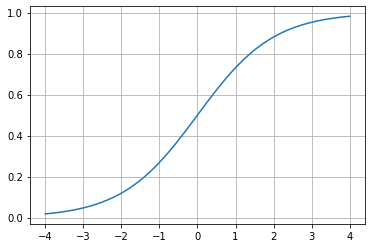

In [ ]:
# Sigmoid 함수
e = np.e

def sigmoid(x) :
  s = 1 / (1 + e**(-x))
  return s

x = np.linspace(-4, 4)
y = sigmoid(x)

plt.plot(x,y)
plt.grid()
plt.show()

- 많은 자연, 사회 현상에서 특정 변수의 확률 값은 선형이 아니라 시그모이드 함수와 같은 S자 커브 형태를 가진다.
- 시그모이드 함수의 정의는 아래와 같다. $$ y = \frac{1}{1 + e^{-x}}$$
  + x 값이 무한대로 가더라도, y 값은 항상 0과 1 사이의 값을 반환한다.
  + x 값이 커지면 1에 근사하고, x 값이 작아지면 0에 근사한다.
  + x = 0일 때, 함수값은 0.5이다.
- 종양 크기에 따라 악성 종양인지 그렇지 않은지 회귀를 이용해 1과 0의 값으로 예측한다. 선형 함수보다 S자 커브 형태의 시그모이드 함수를 이용하면 좀 더 정확하게 분류를 할 수 있다.
- 위스콘신 유방암 데이터셋을 이용해 로지스틱 회귀로 암 여부를 판단한다.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

# 전체 데이터셋 생성
cancer = load_breast_cancer()

- 데이터를 학습/테스트 데이터셋으로 나눈 뒤, 로지스틱 회귀로 분류를 수행한다.
- 선형 회귀 계열인 로지스틱 회귀는 데이터의 분포가 예측 성능에 영향을 주기 때문에, 먼저 데이터를 정규 분포 형태의 표준 스케일링을 적용한 뒤, `train_test_split()`을 이용해 데이터셋을 분리한다.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler()로 평균이 0, 분산 1로 데이터 분포 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size = 0.3, random_state = 0)

- 로지스틱 회귀를 이용해, 학습 및 예측을 수행하고, 정확도와 ROC-AUC 값을 구한다.

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행. 
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

# accuracy와 roc_auc 측정
print('accuracy : {:0.3f}'.format(accuracy_score(y_test, lr_preds)))
print('roc_auc : {:0.3f}'.format(roc_auc_score(y_test , lr_preds)))

accuracy : 0.977
roc_auc : 0.972


- 정확도는 0.977, ROC-AUC는 0.972이다.
- 사이킷런 `LogisticRegression` 클래스의 주요 하이퍼 파라미터는 `penalty`와 `C`가 있다.
  + `penalty` : 규제(Regularization)의 유형을 설정한다. 'l2'이면, L2 규제를, 'l1'이면 L1 규제를 적용한다. 디폴트는 'l2'이다.
  + `C` : 규제 강도를 조절하는 alpha 값의 역수이다. C값이 작을수록 규제 강도가 크다.
- GridSearchCV를 이용해 위스콘신 데이터셋에서 이 하이퍼 파라미터를 최적화해보자.

In [ ]:
from sklearn.model_selection import GridSearchCV

params={'penalty':['l2', 'l1'],
        'C':[0.01, 0.1, 1, 1, 5, 10]}

grid_clf = GridSearchCV(lr_clf, param_grid = params, scoring = 'accuracy', cv = 3 )
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터 : {0}, 최적 평균 정확도 : {1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터 : {'C': 1, 'penalty': 'l2'}, 최적 평균 정확도 : 0.975


- 로지스틱 회귀는 가볍고 빠르지만, 이진 분류 예측 성능도 뛰어나다.
- 로지스틱 회귀는 희소한 데이터셋 분류에서도 뛰어난 성능을 보이며, 텍스트 분류에서도 자주 사용된다.

## **08 회귀 트리**
____
- 지금까지 회귀 계수의 관계를 모두 선형으로 가정하는 선형 회귀에 대해 알아보았다.
- 일반적으로 선형 회귀는 회귀 계수를 선형으로 결합하는 회귀 함수를 구해, 여기에 독립 변수를 입력하여 결과값을 예측하는 방식이다.
- 비선형 회귀 역시 비선형 회귀 함수를 통해 결과값을 예측하며, 다만, 회귀 계수의 결합이 비선형이라는 차이가 있다.
- 머신러닝에서 회귀는 **회귀 계수를 기반으로 하는 최적 회귀 함수를 도출하는 것**이 주요 목표이다.
- 8절에서는 회귀 함수를 기반으로 하지 않고, 결정 트리와 같이, 트리를 기반으로 회귀 방식에 대해 공부한다.
- 트리 기반의 회귀는 회귀 트리를 이용한다. 즉, 회귀를 위한 트리를 생성하고, 이를 기반으로 회귀 예측을 한다.
- 회귀 트리는 분류에서 배운 분류 트리와 크게 다르지 않지만, 리프 노드에서 예측 결정 값을 만드는 과정에 차이가 있다.
  + 분류 트리는 특정 클래스 레이블을 결정한다.
  + 회귀 트리는 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산한다.
- 데이터셋의 X Feature를 결정트리로 분할하면 X 값의 균일도를 반영한 지니 계수에 따라 데이터 값을 분리한다. 루트 노드는 그 값을 기준으로 분할하고, 이렇게 분할된 규칙 노드는 다시 규칙 노드를 분할한다. 리프 노드 생성 기준에 부합하는 트리 분할이 완료되었다면 리프 노드에 소속된 데이터 값의 평균값을 구해 최종적으로 리프 노드에 결정 값을 할당한다.
- CART(Classification And Regression Tree)는 이름에서 알 수 있듯이 분류뿐만 아니라 회귀도 가능한 트리 생성 알고리즘이다. 따라서 결정 트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 등의 모든 트리 기반 알고리즘은 회귀도 가능하다.
- 사이킷런은 결정트리, 랜덤포레스트, GBM에서 CART 기반 회귀를 수행할 수 있는 Estimator 클래스를 재공한다.
- XGBoost, LightGBM도 사이킷런 래퍼 클래스를 통해 이를 제공한다.

|알고리즘|회귀 Estimator 클래스 |분류 Estimator 클래스|
|---|---|---|
|Decision Tree|DecisionTreeRegressor|DecisionTreeClassifier|
|Gradient Boosting|GradientBoostingRegressor|GradientBoostClassifier|
|XGBoost|XGBRegressor|XGBClassifier|
|LightGBM|LGBRegressor|LGBClassifier|


- 사이킷런의 랜덤 포레스트 회귀 트리인 `RandomForestRegressor`를 이용해 보스턴 주택 가격 예측을 수행해보자.

In [ ]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

In [ ]:
# 데이터셋 로드
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

In [ ]:
# Feature/Target 분리
bostonDF['PRICE'] = boston.target
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1,inplace=False)

In [ ]:
# Model Fitting
rf = RandomForestRegressor(random_state = 0, n_estimators = 1000)

# Model Test
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 교차 검증의 개별 Negative MSE scores :  [ -7.88 -13.14 -20.57 -46.23 -18.88]
 5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
 5 교차 검증의 평균 RMSE : 4.423 


- 이번에는 랜덤 포레스트뿐만 아니라, 결정트리, GBM, XGBoost, LightGBM의 `Regressor`를 모두 이용해 보스턴 주택 가격 예측을 수행해보자.
- `get_model_cv_prediction()` 함수 : 입력 모델과 데이터셋을 입력 받아, 교차 검증으로 평균 RMSE를 계산해주는 함수이다.

In [ ]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)

    print('##### ', model.__class__.__name__ , ' #####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

- 이제 다양한 유형의 회귀 트리를 생성하고, 이를 이용해 보스턴 주택 가격을 예측해보자.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
dt_reg = DecisionTreeRegressor(random_state = 0, max_depth = 4)
rf_reg = RandomForestRegressor(random_state = 0, n_estimators = 1000)
gb_reg = GradientBoostingRegressor(random_state = 0, n_estimators = 1000)
xgb_reg = XGBRegressor(n_estimators = 1000)
lgb_reg = LGBMRegressor(n_estimators = 1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행 
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]

for model in models:  
    get_model_cv_prediction(model, X_data, y_target)

#####  DecisionTreeRegressor  #####
 5 교차 검증의 평균 RMSE : 5.978 
#####  RandomForestRegressor  #####
 5 교차 검증의 평균 RMSE : 4.423 
#####  GradientBoostingRegressor  #####
 5 교차 검증의 평균 RMSE : 4.269 
[12:53:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:53:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:53:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:53:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:53:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
#####  XGBRegressor  #####
 5 교차 검증의 평균 RMSE : 4.089 
#####  LGBMRegressor  #####
 5 교차 검증의 평균 RMSE : 4.646 


- 회귀 트리 `Regressor` 클래스는 선형 회귀와 다르게 회귀 계수를 제공하는 `coef_` 속성이 없다.
- 대신 `feature_importances_`를 이용해 Feature 별 중요도를 알 수 있다. 이를 이용해 보스턴 주택 가격 모델의 Feature 별 중요도를 시각화해보자.

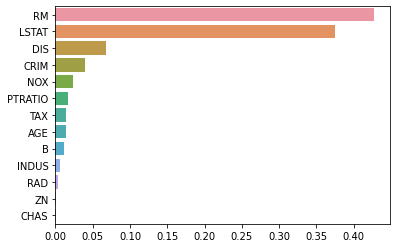

In [ ]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators = 1000)

# 앞에서 만들어진 X_data, y_target 데이터셋을 적용해 학습  
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data = rf_reg.feature_importances_, index = X_data.columns )
feature_series = feature_series.sort_values(ascending = False) # 내림차순
sns.barplot(x = feature_series, y = feature_series.index)

- 사이킷런의 회귀 트리 `Regressor`의 하이퍼 파라미터는 분류 트리 `Classifier`와 거의 동일하다.
- 이번에는 회귀 트리 `Regressor`가 어떻게 예측값을 판단하는지 선형 회귀와 비교해 시각화해보자.
- 결정 트리의 하이퍼 파라미터인 `max_depth`의 크기를 변화시키면서 어떻게 회귀 트리 예측선이 변하는지 살펴본다.
- 보스턴 주택 데이터셋을 이용한다..
- 2차원 평면상에서 회귀 예측선을 쉽게 표현하기 위해  Price와 가장 밀정한 양의 상관관계를 가지는 RM 컬럼만 추출한다.
- 2차원 평면상에서 X축에 독립 변수인 RM, Y축에 종속변수인 PRICE만 두어, 좀 더 직관적으로 예측을 시각화하기 위해, 보스턴 데이터셋의 개수를 100개만 샘플링하고, RM과 PRICE 컬럼을 추출한다.

(100, 2)


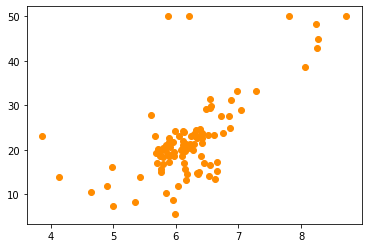

In [ ]:
bostonDF_sample = bostonDF[['RM','PRICE']]
bostonDF_sample = bostonDF_sample.sample( n =100, random_state = 0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")

- 다음으로 보스턴데이터셋에 대해 `LinearRegression`과 `DecisionTreeRegressor`를 `max_depth`를 각각 2, 7로 설정하여 학습한다.
- 이렇게 학습된 Regressor에서 RM 값을 4.5~8.5까지의 값 100개를 테스트 데이터셋으로 제공했을 때 예측값도 구한다.

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성
# DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth = 2)
rf_reg7 = DecisionTreeRegressor(max_depth = 7)

# 실제 예측을 적용할 테스트용 데이터 셋을 4.5 ~ 8.5 까지 100개 테스트 데이터셋 생성
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택가격 데이터에서 시각화를 위해 RM, PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

# 학습
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

# 예측
pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

- 학습된 Regressor에서 예측한 Price 회귀선을 그린다.

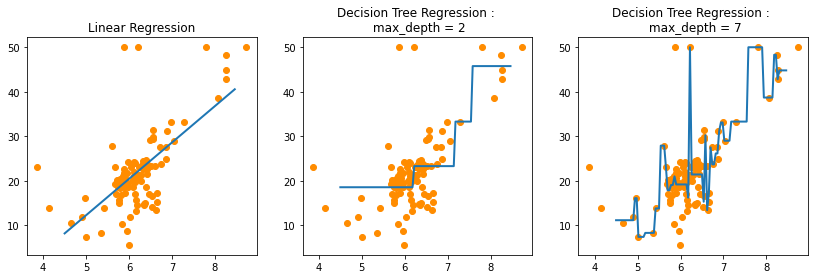

In [ ]:
#  선형 회귀와 결정 트리 회귀 예측선 시각화
fig , (ax1, ax2, ax3) = plt.subplots(figsize = (14,4), ncols = 3)

# 선형 회귀로 학습된 모델 회귀 예측선 
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")
ax1.plot(X_test, pred_lr,label = "linear", linewidth = 2 )

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선 
ax2.set_title('Decision Tree Regression : \n max_depth = 2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")
ax2.plot(X_test, pred_rf2, label = "max_depth : 3", linewidth = 2 )

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선 
ax3.set_title('Decision Tree Regression : \n max_depth = 7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")
ax3.plot(X_test, pred_rf7, label = "max_depth : 7", linewidth = 2)

- 선형 회귀는 직선으로 예측 회귀선을 가지는 반면, 회귀 트리의 경우 분할되는 데이터 지점에 따라 브랜치를 만들면서 계단 형태의 회귀선을 만든다.
- `DecisionTreeRegressor`의 `max_depth = 7`인 경우, 학습 데이터셋의 이상치(Outlier)도 학습하면서 복잡한 계단 형태의 회귀선을 만든 것을 보아, 과적합이 되기 쉬운 모델임을 알 수 있다.